# Parking Availability

## Data
Data set contains:
 - timestamps when a parking session was started and finished: `START_TIME` and `END_TIME`
 - GPS coordinates of the location where a vehicle was parked: `Lon` and `Lat`

In [2]:
from bokeh.io import output_notebook, show
from bokeh.models import (GMapOptions, ColumnDataSource)
from bokeh.models.glyphs import Text
from bokeh.plotting import gmap

import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

import itertools

In [3]:
area_title = 'IJburg'
file_name_prefix = area_title.lower() + '_'
area_lat = 52.355
area_lon = 5
area_zoom = 14

restrict_initial_data_to = -1 #100000

v_area_split_by = 5 #11
h_area_split_by = 5 #11

downsampling_interval_in_minutes = 60

enforcement_start = 8
enforcement_end = 23
no_enforcement_weekdays = [6]

limit_by_spots = -1

GOOGLE_API_KEY = ''
with open('google_api.key', 'r') as myfile:
    GOOGLE_API_KEY = myfile.read()

In [4]:
class DataSetCleaner(object):
    def __init__(self, start_time, end_time, ignore_weekdays=None):
        self._start_time = start_time
        self._end_time = end_time
        self._ignore_weekdays = ignore_weekdays
        
        if self._ignore_weekdays == None:
            self._ignore_weekdays = []
        
    def cleanup(self, df, start_time_column, stop_time_column, inplace=False):
        to_drop = df[(df[start_time_column].dt.hour < self._start_time) | (df[stop_time_column].dt.hour > self._end_time) | (df[start_time_column].dt.dayofweek.isin(self._ignore_weekdays))].index
        
        if inplace:
            df.drop(to_drop, inplace=inplace)
        else:
            return df.drop(to_drop, inplace=inplace)

In [5]:
df = pd.read_csv('ijburg2017april_sep3.csv')
df.head()

START_TIME                STOP_TIME       Lon        Lat
0  2017-09-30 21:40:00.250  2017-09-30 21:40:08.593  4.990345  52.358908
1  2017-09-30 20:25:02.600  2017-09-30 20:25:32.710  5.007608  52.350011
2  2017-09-30 19:15:51.303  2017-09-30 19:17:02.013  5.015789  52.354633
3  2017-09-30 19:06:02.730  2017-09-30 20:23:53.023  4.993960  52.354604
4  2017-09-30 18:46:00.973  2017-09-30 22:21:13.130  4.994605  52.357612

Cast timestamps to the propper type.

In [6]:
df.START_TIME = pd.to_datetime(df.START_TIME)
df.STOP_TIME = pd.to_datetime(df.STOP_TIME)
df.dtypes

START_TIME    datetime64[ns]
STOP_TIME     datetime64[ns]
Lon                  float64
Lat                  float64
dtype: object

In [7]:
ds_cleaner = DataSetCleaner(enforcement_start, enforcement_end, ignore_weekdays=no_enforcement_weekdays)

print('{0} - size of df before dropping rows'.format(len(df)))
ds_cleaner.cleanup(df, 'START_TIME', 'STOP_TIME', inplace=True)
print('{0} - size of df before dropping rows'.format(len(df)))

119436 - size of df before dropping rows
99110 - size of df before dropping rows


Restrict the dataset. Data volumes of big size cannot be handled on the later steps.

In [8]:
if restrict_initial_data_to > -1:
    df = df.head(restrict_initial_data_to)

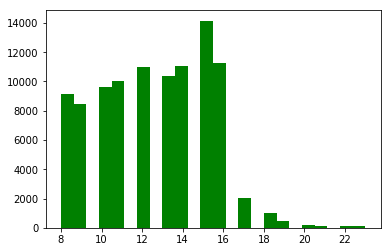

In [9]:
n, bins, patches = plt.hist(df['START_TIME'].dt.hour.values, 24, facecolor='green')

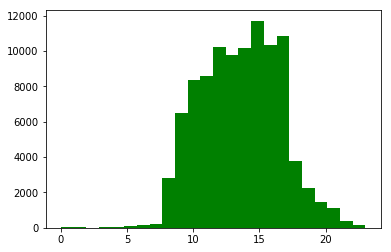

In [10]:
n, bins, patches = plt.hist(df['STOP_TIME'].dt.hour.values, 24, facecolor='green')

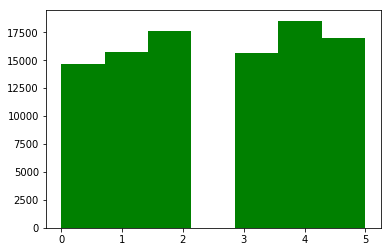

In [11]:
n, bins, patches = plt.hist(df['START_TIME'].dt.dayofweek.values, 7, facecolor='green')

## Data visualization

Let's plot the points we have on the map

In [12]:
map_options = GMapOptions(lat=area_lat, lng=area_lon, map_type="roadmap", zoom=area_zoom)
plot = gmap(GOOGLE_API_KEY, map_options, title=area_title)

source = ColumnDataSource(
    data=dict(
        lat=df.Lat.values,
        lon=df.Lon.values)
)

plot.circle(x="lon", y="lat", size=1, fill_color='blue', fill_alpha=0.8, source=source)
output_notebook()

show(plot)

Loading BokehJS ...

## Area split

We don't want to predict availability for each location but for bigger zone. Let's group locations into squared areas. 

We will mark each area by its index and each pair of Lat & Lon can be mapped to the index. 

`index = lon * amount_of_cols + lat`


In [19]:
class CoordinatesMapper(object):
    def __init__(self, minLon, minLat, maxLon, maxLat, hCount = 11, vCount = 11):
        ''' Maps lat lon to a cell.
            Keyword arguments:
            minLon -- min lon in data set
            minLat -- min lat in data set
            maxLon -- max lon in data set
            maxLat -- max lat in data set
            hCount -- amount of areas horisontally
            vCount -- amount of areas vertically
        '''
        self._ndig = 3
        self._minLon = minLon
        self._minLat = minLat
        self._maxLon = maxLon
        self._maxLat = maxLat
        self._hCount = hCount
        self._vCount = vCount
        self._cell_width_lon = round((self._maxLon - self._minLon) / self._hCount, self._ndig)
        self._cell_height_lat = round((self._maxLat - self._minLat) / self._vCount, self._ndig)
        
    def toIndex(self, lon, lat):
        y = int(round(lat - self._minLat, self._ndig) / self._cell_height_lat)
        x = int((lon - self._minLon) / self._cell_width_lon)
        
        return self._hCount * y + x
    
    def getRects(self):
        dlon = self._cell_width_lon
        dlat = self._cell_height_lat
        lon_c = self._cell_width_lon / 2
        lat_c = self._cell_height_lat / 2
        
        rows = []
        
        for y in range(self._vCount+1):
            for x in range(self._hCount):
                rect = [self._minLon + x * dlon + lon_c, self._minLat + y * dlat + lat_c,  str(y * self._hCount + x) ] 
                rows.append(rect)
                
        return pd.DataFrame(rows, columns=['x', 'y', 'index'])
        

Add a new column that will hold the area index

In [20]:
mapper = CoordinatesMapper(df.Lon.min(), df.Lat.min(), df.Lon.max(), df.Lat.max(), hCount = h_area_split_by, vCount = v_area_split_by)

In [21]:
df['zone_index'] = df.apply(lambda row: mapper.toIndex(row['Lon'] ,row['Lat']), axis = 1)
print ('Area is split into {0} unique subareas'.format( df['zone_index'].nunique()))

Area is split into 31 unique subareas


## Areas visualization

Let's display the areas after the split.


In [22]:
rects = mapper.getRects()
rects.describe()

x          y
count  30.000000  30.000000
mean    5.000021  52.354139
std     0.008630   0.005211
min     4.988021  52.346639
25%     4.994021  52.349639
50%     5.000021  52.354139
75%     5.006021  52.358639
max     5.012021  52.361639

In [23]:
map_options = GMapOptions(lat=area_lat, lng=area_lon, map_type="roadmap", zoom=area_zoom)

plot = gmap(GOOGLE_API_KEY, map_options, title=area_title)

colors = ['#ff0000', '#00ff00', '#0000ff', '#ffff00', '#ff00ff', '00ffff', "#880977"]

points_colors = df.apply(lambda row: colors[int(row['zone_index'] % len(colors))] , axis = 1).values

source = ColumnDataSource(
    data=dict(
        lat=df.Lat.values,
        lon=df.Lon.values,
        color = points_colors
    )
)

index_source = ColumnDataSource(
    data=dict(
        x=rects.x.values, 
        y=rects.y.values, 
        text=rects.index.values)
)

glyph = Text(x="x", y="y", text="text", text_color="#ffffff")

plot.circle(x="lon", y="lat", size=2, line_color='color', fill_color='color', fill_alpha=0.2, source=source)

plot.rect(x=rects.x.values, y=rects.y.values, width=650, height=520, tags=list(rects.index.values), alpha=0.5)
plot.add_glyph(index_source, glyph)

output_notebook()

show(plot)

Loading BokehJS ...

In [24]:
to_drop = df[(df.zone_index.isin([0, 1, 2, 5, 6, 10,19, 23, 24, 27,28,29,30 ]))].index
df.drop(to_drop, inplace=True)

In [25]:
map_options = GMapOptions(lat=area_lat, lng=area_lon, map_type="roadmap", zoom=area_zoom)

plot = gmap(GOOGLE_API_KEY, map_options, title=area_title)

colors = ['#ff0000', '#00ff00', '#0000ff', '#ffff00', '#ff00ff', '00ffff', "#880977"]

points_colors = df.apply(lambda row: colors[int(row['zone_index'] % len(colors))] , axis = 1).values

source = ColumnDataSource(
    data=dict(
        lat=df.Lat.values,
        lon=df.Lon.values,
        color = points_colors
    )
)

index_source = ColumnDataSource(
    data=dict(
        x=rects.x.values, 
        y=rects.y.values, 
        text=rects.index.values)
)

glyph = Text(x="x", y="y", text="text", text_color="#ffffff")

plot.circle(x="lon", y="lat", size=2, line_color='color', fill_color='color', fill_alpha=0.2, source=source)

plot.rect(x=rects.x.values, y=rects.y.values, width=650, height=520, tags=list(rects.index.values), alpha=0.5)
plot.add_glyph(index_source, glyph)

output_notebook()

show(plot)

Loading BokehJS ...

## Downsample the time intervals

In [26]:
# The following approach is wrong.
#df['same_time_parkings'] = df.apply(lambda row:  df[(row.zone_index == df.zone_index) & (row.START_TIME < df.STOP_TIME) & (row.STOP_TIME > df.START_TIME)]['START_TIME'].count(), axis = 1)
#df.groupby('zone_index')['same_time_parkings'].max()

In [27]:
zones = df.zone_index.unique()
zones.sort()
zones

array([ 3,  4,  7,  8,  9, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 25,
       26])

In [28]:
period_start = df.START_TIME.min().normalize()
period_end = df.STOP_TIME.max().normalize()

print('{0} - {1}'.format(period_start, period_end))

2017-04-03 00:00:00 - 2017-10-01 00:00:00


In [29]:
timestamps = pd.date_range(period_start, period_end, freq='{0}min'.format(downsampling_interval_in_minutes)).values
timestamps

array(['2017-04-03T00:00:00.000000000', '2017-04-03T01:00:00.000000000',
       '2017-04-03T02:00:00.000000000', ...,
       '2017-09-30T22:00:00.000000000', '2017-09-30T23:00:00.000000000',
       '2017-10-01T00:00:00.000000000'], dtype='datetime64[ns]')

In [30]:
lists = [timestamps, zones]
zones_availability = pd.DataFrame(list(itertools.product(*lists)), columns=['timestamp', 'zone_index'])

print('{0} - size of df before dropping rows'.format(len(zones_availability)))
ds_cleaner.cleanup(zones_availability, 'timestamp', 'timestamp', inplace=True)
print('{0} - size of df before dropping rows'.format(len(zones_availability)))

zones_availability = zones_availability.sort_values(by=['zone_index', 'timestamp'])
zones_availability['parked'] = 0
zones_availability.head()

78210 - size of df before dropping rows
44928 - size of df before dropping rows


timestamp  zone_index  parked
144 2017-04-03 08:00:00           3       0
162 2017-04-03 09:00:00           3       0
180 2017-04-03 10:00:00           3       0
198 2017-04-03 11:00:00           3       0
216 2017-04-03 12:00:00           3       0

In [31]:
#rows = [['2017-09-30 11:02:00','2017-09-30 11:15:00',1],
#['2017-09-30 11:33:00','2017-09-30 11:54:00',1],
#['2017-09-30 12:43:00','2017-09-30 13:50:00',1],
#['2017-09-30 12:50:00','2017-09-30 12:58:00',1],
#['2017-09-30 12:56:00','2017-09-30 14:24:00',1]]
#df = pd.DataFrame(rows, columns=['START_TIME','STOP_TIME', 'zone_index'])

#df.START_TIME = pd.to_datetime(df.START_TIME)
#df.STOP_TIME = pd.to_datetime(df.STOP_TIME)
#df.dtypes

#timestamps = pd.DataFrame(pd.Series(pd.date_range('2017-09-29 00:00:00', '2017-09-30 00:00:00', freq="30min").values), columns=['timestamp'])
#zones = pd.DataFrame(pd.Series([1, 2]), columns=['zone'])
#lists = [timestamps['timestamp'].values, zones['zone'].values]
#res = pd.DataFrame(list(itertools.product(*lists)), columns=['timestamp', 'zone'])
#res.sort_values(by=['zone'])

In [32]:
def downsample_time(start, end, zone_index, minutes):
    result = []
    
    stamp = pd.Timestamp(start.date())
    
    for i in range(len(ranges)-1):
        st = stamp + ranges[i]
        ed = stamp + ranges[i + 1]
        
        #print ('st={0}, ed={1}, -- start={2}, end={3}'.format(st, ed, start, end))
        if start < ed and end > st:
            result.append([st, zone_index, 1])
    
    return result

In [33]:
ranges = pd.timedelta_range('0 days 0 hours 0 minutes', periods=(24*60)/downsampling_interval_in_minutes, freq='{0}min'.format(downsampling_interval_in_minutes))

rows = []
for i, row in df.iterrows():
    rows += downsample_time(row.START_TIME, row.STOP_TIME, row.zone_index, ranges)

In [34]:
downsampled_time_df = pd.DataFrame(rows, columns=['timestamp','zone_index', 'parked'])

print('{0} - size of df before dropping rows'.format(len(downsampled_time_df)))
ds_cleaner.cleanup(downsampled_time_df, 'timestamp', 'timestamp', inplace=True)
print('{0} - size of df after dropping rows'.format(len(downsampled_time_df)))

229354 - size of df before dropping rows
229354 - size of df after dropping rows


In [35]:
downsampled_time_df = pd.concat([zones_availability, downsampled_time_df])
downsampled_time_df = downsampled_time_df.groupby(['timestamp','zone_index'], as_index=False).sum()

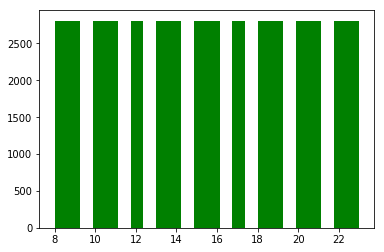

In [36]:
n, bins, patches = plt.hist(downsampled_time_df.timestamp.dt.hour.values, 24, facecolor='green')

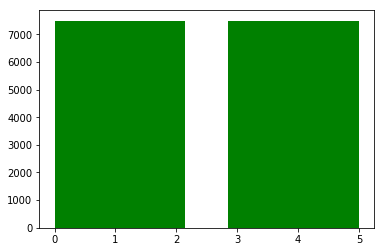

In [37]:
n, bins, patches = plt.hist(downsampled_time_df.timestamp.dt.dayofweek.values, 7, facecolor='green')

In [38]:
downsampled_time_df.describe()

zone_index        parked
count  44928.000000  44928.000000
mean      14.500000      5.104923
std        6.601841      7.271839
min        3.000000      0.000000
25%        9.000000      0.000000
50%       14.500000      2.000000
75%       20.000000      6.000000
max       26.000000     71.000000

## Save DataFrame with downsampled timestamps

In [39]:
downsampled_time_df.to_csv(file_name_prefix + 'downsampled_time.csv', index=False)

## Read DataFrame with downsampled timestamps

In [40]:
downsampled_time_df = pd.read_csv(file_name_prefix + 'downsampled_time.csv')
downsampled_time_df.timestamp = pd.to_datetime(downsampled_time_df.timestamp)
downsampled_time_df.dtypes

timestamp     datetime64[ns]
zone_index             int64
parked                 int64
dtype: object

In [41]:
len(downsampled_time_df)

44928

In [42]:
len(downsampled_time_df[downsampled_time_df.parked == 0])

12090

## Area capacity

We estimate total amount of parking spots by historical max amount of simultaniously parked cars.

In [43]:
zone_capacity = downsampled_time_df.groupby(['timestamp','zone_index'], as_index=False).sum().groupby('zone_index', as_index=False).max()
zone_capacity = zone_capacity.drop(columns=['timestamp'])
zone_capacity = zone_capacity.rename({'parked': 'spots_amount'}, axis='columns')
zone_capacity.describe()

zone_index  spots_amount
count   18.000000     18.000000
mean    14.500000     33.222222
std      6.793163     22.177242
min      3.000000      2.000000
25%      9.500000     15.500000
50%     14.500000     29.000000
75%     19.500000     51.500000
max     26.000000     71.000000

In [44]:
#zone_capacity.sort_values(by=['spots_amount','zone_index'], ascending=False)
zone_capacity

zone_index  spots_amount
0            3             9
1            4            28
2            7             8
3            8            50
4            9            67
5           11            18
6           12            66
7           13            57
8           14            71
9           15            32
10          16            27
11          17            30
12          18             2
13          20            52
14          21            36
15          22            15
16          25            17
17          26            13

In [45]:
downsampled_time_df.head()

timestamp  zone_index  parked
0 2017-04-03 08:00:00           3       1
1 2017-04-03 08:00:00           4       1
2 2017-04-03 08:00:00           7       1
3 2017-04-03 08:00:00           8       2
4 2017-04-03 08:00:00           9       1

In [46]:
parking_per_datetime=downsampled_time_df.join(zone_capacity.set_index('zone_index'),  on='zone_index',how='left' )
parking_per_datetime.head(20)

timestamp  zone_index  parked  spots_amount
0  2017-04-03 08:00:00           3       1             9
1  2017-04-03 08:00:00           4       1            28
2  2017-04-03 08:00:00           7       1             8
3  2017-04-03 08:00:00           8       2            50
4  2017-04-03 08:00:00           9       1            67
5  2017-04-03 08:00:00          11       1            18
6  2017-04-03 08:00:00          12       3            66
7  2017-04-03 08:00:00          13       5            57
8  2017-04-03 08:00:00          14       0            71
9  2017-04-03 08:00:00          15       1            32
10 2017-04-03 08:00:00          16       5            27
11 2017-04-03 08:00:00          17       5            30
12 2017-04-03 08:00:00          18       0             2
13 2017-04-03 08:00:00          20       6            52
14 2017-04-03 08:00:00          21       6            36
15 2017-04-03 08:00:00          22       0            15
16 2017-04-03 08:00:00          25       2            17
17 2017-04-03 08:00:00          26       0            13
18 2017-04-03 09:00:00           3       1             9
19 2017-04-03 09:00:00           4       0            28

In [47]:
if limit_by_spots > -1:
    parking_per_datetime = parking_per_datetime[parking_per_datetime.spots_amount >= limit_by_spots]

## Create Availability labels

For now it will be only two labels:
 - free
 - busy
 
Label is 1(busy) when ratio parked/capacity > 0.5, otherwise it is 0(free)

In [48]:
parking_per_datetime['availability'] = round((parking_per_datetime['parked'] / parking_per_datetime['spots_amount']))
parking_per_datetime.head()

timestamp  zone_index  parked  spots_amount  availability
0 2017-04-03 08:00:00           3       1             9           0.0
1 2017-04-03 08:00:00           4       1            28           0.0
2 2017-04-03 08:00:00           7       1             8           0.0
3 2017-04-03 08:00:00           8       2            50           0.0
4 2017-04-03 08:00:00           9       1            67           0.0

In [49]:
#sorteddf = parking_per_datetime.sort_values(by=['zone_index', 'timestamp'])
#sorteddf.to_csv(file_name_prefix + 'sorted.csv', index=False)

## TODO

In [50]:
parking_per_datetime.describe()

zone_index        parked  spots_amount  availability
count  44928.000000  44928.000000  44928.000000  44928.000000
mean      14.500000      5.104923     33.222222      0.046964
std        6.601841      7.271839     21.552645      0.211564
min        3.000000      0.000000      2.000000      0.000000
25%        9.000000      0.000000     15.000000      0.000000
50%       14.500000      2.000000     29.000000      0.000000
75%       20.000000      6.000000     52.000000      0.000000
max       26.000000     71.000000     71.000000      1.000000

In [51]:
zdf = parking_per_datetime
#len(zdf[zdf.spots_amount < 5])
(len(zdf[zdf.availability == 1]) / len(zdf))*100

4.696403133903134

In [87]:
zone_info = parking_per_datetime.groupby(['zone_index', 'availability'], as_index=False).count()

zone_info = zone_info.drop(columns=['parked', 'spots_amount'])
zone_info = zone_info.rename({'timestamp': 'records_count'}, axis='columns')
zone_info['1_label_count'] = zone_info['availability'] * zone_info['records_count']
zone_info['0_label_count'] = (1 - zone_info['availability']) * zone_info['records_count']
zone_info = zone_info.groupby(['zone_index'], as_index=False).max()
zone_info = zone_info.drop(columns=['availability'])
zone_info['records_count'] = zone_info['0_label_count'] + zone_info['1_label_count']

zone_info['k'] = zone_info['1_label_count'] / zone_info['records_count']
zone_info=zone_info.join(zone_capacity.set_index('zone_index'),  on='zone_index',how='left' )

zone_info = zone_info.sort_values(by=['k','1_label_count'], ascending=False)

zone_info

zone_index  records_count  weekday  hour  1_label_count  0_label_count  \
10          16         2496.0     2102  2102          394.0         2102.0   
13          20         2496.0     2111  2111          385.0         2111.0   
7           13         2496.0     2124  2124          372.0         2124.0   
17          26         2496.0     2287  2287          209.0         2287.0   
14          21         2496.0     2297  2297          199.0         2297.0   
16          25         2496.0     2347  2347          149.0         2347.0   
0            3         2496.0     2392  2392          104.0         2392.0   
6           12         2496.0     2434  2434           62.0         2434.0   
2            7         2496.0     2444  2444           52.0         2444.0   
5           11         2496.0     2455  2455           41.0         2455.0   
8           14         2496.0     2461  2461           35.0         2461.0   
15          22         2496.0     2464  2464           32.0         2464.0   
3            8         2496.0     2470  2470           26.0         2470.0   
4            9         2496.0     2480  2480           16.0         2480.0   
9           15         2496.0     2481  2481           15.0         2481.0   
12          18         2496.0     2487  2487            9.0         2487.0   
1            4         2496.0     2489  2489            7.0         2489.0   
11          17         2496.0     2493  2493            3.0         2493.0   

           k  spots_amount  
10  0.157853            27  
13  0.154247            52  
7   0.149038            57  
17  0.083734            13  
14  0.079728            36  
16  0.059696            17  
0   0.041667             9  
6   0.024840            66  
2   0.020833             8  
5   0.016426            18  
8   0.014022            71  
15  0.012821            15  
3   0.010417            50  
4   0.006410            67  
9   0.006010            32  
12  0.003606             2  
1   0.002804            28  
11  0.001202            30

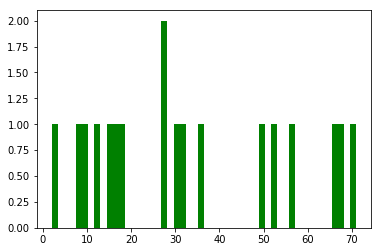

In [88]:
mu, sigma = 100, 15
x = zone_info.spots_amount.values

# the histogram of the data
n, bins, patches = plt.hist(x, 50, facecolor='green')

## Extract more features

In [136]:
weekdays = parking_per_datetime.timestamp.dt.weekday
parking_per_datetime = parking_per_datetime.assign(weekday = weekdays)
parking_per_datetime = parking_per_datetime.assign(hour = parking_per_datetime.timestamp.dt.hour)

In [137]:
dummies = pd.get_dummies(parking_per_datetime, columns=['zone_index','weekday', 'hour'])
dummies.columns

Index(['timestamp', 'parked', 'spots_amount', 'availability', 'zone_index_3',
       'zone_index_4', 'zone_index_7', 'zone_index_8', 'zone_index_9',
       'zone_index_11', 'zone_index_12', 'zone_index_13', 'zone_index_14',
       'zone_index_15', 'zone_index_16', 'zone_index_17', 'zone_index_18',
       'zone_index_20', 'zone_index_21', 'zone_index_22', 'zone_index_25',
       'zone_index_26', 'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3',
       'weekday_4', 'weekday_5', 'hour_8', 'hour_9', 'hour_10', 'hour_11',
       'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17',
       'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23'],
      dtype='object')

In [138]:
dummies.sort_values(by=['timestamp'], inplace=True)
dummies.drop(columns=['parked', 'spots_amount',], inplace=True)

## Train a model

In [139]:
from datetime import datetime, timedelta

d1 = dummies.timestamp.min()
d2 = dummies.timestamp.max()

monday1 = (d1 - timedelta(days=d1.weekday()))
monday2 = (d2 - timedelta(days=d2.weekday()))
weeks = round((monday2 - monday1).days / 7.0) + 1

print ('Weeks:', weeks)

training_weeks = round(weeks * 0.7)
print ('Training Weeks:', training_weeks)

validate_weeks = round((weeks - training_weeks) / 2)
print ('Validate Weeks:', validate_weeks)

test_weeks = weeks - training_weeks - validate_weeks
print ('Test Weeks:', test_weeks)

Weeks: 26
Training Weeks: 18
Validate Weeks: 4
Test Weeks: 4


In [140]:
end_training_data_date = dummies.timestamp.min() + timedelta(weeks=training_weeks)
print('Training data untill: {0}'.format( end_training_data_date))

end_validate_data_date = dummies.timestamp.min() + timedelta(weeks=training_weeks + validate_weeks)
print('Validate data untill: {0}'.format(end_validate_data_date))

end_test_data_date = dummies.timestamp.min() + timedelta(weeks=training_weeks + validate_weeks + test_weeks)
print('Test data untill: {0}'.format(end_test_data_date))

Training data untill: 2017-08-07 08:00:00
Validate data untill: 2017-09-04 08:00:00
Test data untill: 2017-10-02 08:00:00


In [141]:
X_train = dummies[dummies.timestamp < end_training_data_date]
y_train = X_train['availability']

In [142]:
y_train.sum()/len(y_train)

0.044206532921810697

In [143]:
validate_and_test = dummies[dummies.timestamp >= end_training_data_date]

In [144]:
X_validate = validate_and_test[validate_and_test.timestamp < end_validate_data_date]
y_validate = X_validate['availability']

In [145]:
y_validate.sum()/len(y_validate)

0.032841435185185182

In [146]:
X_test = validate_and_test[validate_and_test.timestamp >= end_validate_data_date]
y_test = X_test['availability']

In [147]:
y_test.sum()/len(y_test)

0.073495370370370364

In [148]:
X_train.drop(columns=['timestamp', 'availability'], inplace=True)
X_validate.drop(columns=['timestamp','availability'], inplace=True)
X_test.drop(columns=['timestamp','availability'], inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [171]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn import metrics

lambdas = [0.000001,0.0000095,0.00005,0.0001,0.0005,0.001]

models = {}

for lambda_ in lambdas:
    clf = SGDClassifier(loss ='log', penalty='l1', alpha=lambda_, random_state=100, max_iter=1000, tol=0.001).fit(X_train.values, y_train.values)
    y_pred = clf.decision_function(X_validate.values)
    fpr, tpr, thresholds = metrics.roc_curve(y_validate.values, y_pred)
    auc = metrics.auc(fpr, tpr)
    models[auc] = clf
    print(auc)

0.823666305326
0.824327922003
0.818808299204
0.833270290841
0.83320834665
0.832834045582


In [173]:
clf = models[max(models.keys())]

y_pred = clf.decision_function(X_validate.values)
fpr, tpr, thresholds = metrics.roc_curve(y_validate.values, y_pred)
auc = metrics.auc(fpr, tpr)


In [174]:
auc

0.833270290841156

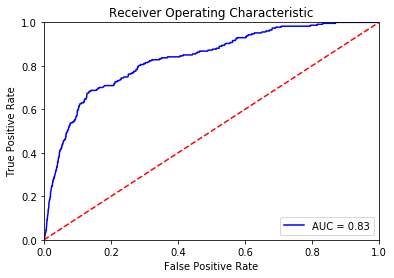

In [175]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

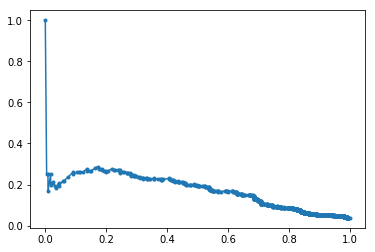

In [176]:
precision, recall, thresholds = metrics.precision_recall_curve(y_validate.values, y_pred)
plt.plot(recall, precision, marker='.')
plt.show()

In [121]:
fdf = pd.DataFrame(X_train.columns)
fdf['k'] = pd.Series(m.coef_[0])
fdf.sort_values(by=['k'], inplace=True)
fdf

0          k
39        hour_23 -83.896740
24         hour_8 -67.335961
38        hour_22 -56.420336
11  zone_index_17  -2.985371
1    zone_index_4  -2.375586
12  zone_index_18  -1.924659
3    zone_index_8  -1.385024
9   zone_index_15  -1.383223
4    zone_index_9  -1.014706
21      weekday_3  -0.944830
8   zone_index_14  -0.913114
5   zone_index_11  -0.548362
15  zone_index_22  -0.504493
18      weekday_0  -0.285852
20      weekday_2  -0.202964
22      weekday_4   0.000000
0    zone_index_3   0.000000
19      weekday_1   0.000000
2    zone_index_7   0.000000
6   zone_index_12   0.000000
14  zone_index_21   0.453385
16  zone_index_25   0.557573
23      weekday_5   0.679316
17  zone_index_26   1.367727
7   zone_index_13   2.356927
10  zone_index_16   2.452605
13  zone_index_20   3.138648
37        hour_21   8.057429
36        hour_20   8.729959
35        hour_19   9.213642
34        hour_18   9.428488
25         hour_9  10.337007
26        hour_10  11.823258
27        hour_11  11.967163
33        hour_17  12.099111
29        hour_13  12.937141
28        hour_12  13.071059
31        hour_15  13.747980
30        hour_14  14.092611
32        hour_16  14.418478

In [172]:
from sklearn.ensemble import RandomForestClassifier

ns = [2, 5, 10, 20, 50, 100]

ds = [2, 4, 6, 8, 10, 20, 30, 40]

#n = 100
#d = 2

for n in ns:
    for d in ds:
        clf = RandomForestClassifier(n_estimators=n, max_depth=d, random_state=100)
        clf.fit(X_train.values, y_train.values)
        y_pred = clf.predict(X_validate.values)
        fpr, tpr, thresholds = metrics.roc_curve(y_validate.values, y_pred)
        auc = metrics.auc(fpr, tpr)
        print('n:{0} d:{1} = auc:{2}'.format(n,d, auc))

AttributeError: 'RandomForestClassifier' object has no attribute 'decision_function'

Random Forest doesn't outperform the previous model (which was Gradient Descent classifier). That is why we will choose the SGD classifier. We will try to add some new features.

First let's add feature interaction and see what will happen.

In [150]:
class FeatureProcessor(object):
    def add_interaction(self, df, columns):
        # collect the columns
        cols = {}

        for c in columns:
            cols[c] = []

        for dfc in df.columns:
            for c in columns:
                if dfc.startswith(c):
                    cols[c].append(dfc)

        keys = []

        for k in cols.keys():
            keys.append(k)

        new_keys = []
        self._combine(keys, 0, new_keys, cols, len(columns), [])

        for n_key in new_keys:
            n_key_name = self._to_name(n_key)
            df[n_key_name] = df.apply(lambda row: self._get_row_val(row, n_key) , axis = 1)

    def _get_row_val(self, row, n_key):
        all_ones = 1
        for nk in n_key:
            if row[nk]!=1:
                all_ones = 0
                break
        return all_ones

    def _to_name(self, key):
        return '_'.join(key)

    def _combine(self, keys, idx, res, cols, n, cur_key):

        if len(cur_key) == n:
            res.append(cur_key)

        if idx >= n:
            return

        for i in range(idx, len(keys)):
            k = keys[i]
            vals = cols[k]
            for j in range(len(vals)):
                self._combine(keys, i+1, res,cols, n, cur_key + [vals[j]])

In [151]:
dummies.columns.get_values()

array(['availability', 'zone_index_3', 'zone_index_4', 'zone_index_7',
       'zone_index_8', 'zone_index_9', 'zone_index_11', 'zone_index_12',
       'zone_index_13', 'zone_index_14', 'zone_index_15', 'zone_index_16',
       'zone_index_17', 'zone_index_20', 'zone_index_21', 'zone_index_22',
       'zone_index_25', 'zone_index_26', 'weekday_0', 'weekday_1',
       'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'hour_6',
       'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12',
       'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18',
       'hour_19', 'hour_20', 'hour_21', 'hour_22'], dtype=object)

In [152]:
#size = len(dummies)
#sample = dummies.head(100)

In [349]:
fp = FeatureProcessor()
fp.add_interaction(dummies, columns=['weekday', 'hour'])
dummies.columns.get_values()

array(['availability', 'zone_index_3', 'zone_index_4', 'zone_index_7',
       'zone_index_8', 'zone_index_9', 'zone_index_11', 'zone_index_12',
       'zone_index_13', 'zone_index_14', 'zone_index_15', 'zone_index_16',
       'zone_index_17', 'zone_index_18', 'zone_index_20', 'zone_index_21',
       'zone_index_22', 'zone_index_25', 'zone_index_26', 'weekday_0',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13',
       'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19',
       'hour_20', 'hour_21', 'hour_22', 'hour_23', 'weekday_0_hour_8',
       'weekday_0_hour_9', 'weekday_0_hour_10', 'weekday_0_hour_11',
       'weekday_0_hour_12', 'weekday_0_hour_13', 'weekday_0_hour_14',
       'weekday_0_hour_15', 'weekday_0_hour_16', 'weekday_0_hour_17',
       'weekday_0_hour_18', 'weekday_0_hour_19', 'weekday_0_hour_20',
       'weekday_0_hour_21', 'weekday_0_hour_22', 'weekday_0_hour_23',

In [154]:
len(dummies.columns.get_values())

143

In [155]:
training_size = int(len(dummies) * 0.7)
validation_size = int(len(dummies) * 0.15)
test_size = len(dummies) - training_size - validation_size

In [157]:
X_train = dummies.head(training_size)
y_train = X_train['availability']
X_train.drop(columns=['availability'], inplace=True)

In [158]:
validate_and_test = dummies.tail(validation_size + test_size)

In [159]:
X_validate = validate_and_test.head(validation_size)
y_validate = X_validate['availability']
X_validate.drop(columns=['availability'], inplace=True)

In [160]:
X_test = validate_and_test.tail(test_size)
y_test = X_test['availability']
X_test.drop(columns=['availability'], inplace=True)

In [161]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn import metrics

#lambdas = [0.00000001,0.0000001,0.00000013,0.00000015,0.00000017,0.00000019]

lambdas = [0.0000000001,0.000000005,0.00000001,0.0000001,0.000001,0.00001,0.0001]

models = {}

for lambda_ in lambdas:
    clf = SGDClassifier(loss ='log', penalty='l2', alpha=lambda_, random_state=100).fit(X_train.values, y_train.values)
    y_pred = clf.predict(X_validate.values)
    fpr, tpr, thresholds = metrics.roc_curve(y_validate.values, y_pred)
    auc = metrics.auc(fpr, tpr)
    models[auc] = clf
    print(auc)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


0.530373559874


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


0.56140657124


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


0.530373559874


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


0.54942588929


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


0.584444703053


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


0.53759067458


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


0.531721556306
